# Fix pathing

In [1]:
import sys


sys.path.append("../..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))))


# Imports

In [3]:
import json
import matplotlib.pyplot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pandas as pd
import IPython.display
from kneed import KneeLocator


# Constants

In [4]:
FOLDER_NAMES = ["ex_5_least_NSGA2", "ex_5_avg_NSGA2", "ex_5_most_NSGA2"]
FILE_INFO = {
    "ex_5_least_NSGA2": ("Lowest Activity", "green"),

    "ex_5_avg_NSGA2": ("Average Activity", "yellow"),

    "ex_5_most_NSGA2": ("Highest Activity", "red"),
}

FOLDER_PATH = os.path.join(os.path.dirname(constants.PROJECT_DIRECTORY_PATH), "Simulator", "data")

RESOURCE_SIZES = list(range(30, 61))

deep_palette = sns.color_palette("deep")
deep_colors = {
    "yellow": deep_palette[0], # actually blue
    "orange": deep_palette[1],
    "green": deep_palette[2],
    "red": deep_palette[3],
}

bright_palette = sns.color_palette("bright")
bright_colors = {
    "yellow": bright_palette[0], # actually blue
    "orange": bright_palette[1],
    "green": bright_palette[2],
    "red": bright_palette[3],
}


# Methods

In [5]:
def load_json():
    dataset = {}

    for folder_name in FOLDER_NAMES:
        for resource_size in RESOURCE_SIZES:
            day, color = FILE_INFO[folder_name]

            with open(os.path.join(FOLDER_PATH, folder_name, f"heuristic_numAmbulances={resource_size}.json"), 'r') as file:
                dataset[(day, color, resource_size)] = json.load(file)

    return dataset


In [6]:
def compute_metrics(dataset):
    dataframe = pd.DataFrame()

    dataframe["day"] = "None"
    dataframe["color"] = "None"
    dataframe["resource_size"] = 0
    dataframe["generation"] = 0
    dataframe["individual"] = 0
    dataframe["diversity"] = 0
    dataframe["front_number"] = np.nan
    dataframe["crowding_distance"] = np.nan
    dataframe["percentage_violations"] = 0
    dataframe["percentage_violations_urban"] = 0
    dataframe["percentage_violations_rural"] = 0
    dataframe["avg_response_time_urban_a"] = 0
    dataframe["avg_response_time_urban_h"] = 0
    dataframe["avg_response_time_urban_v1"] = 0
    dataframe["avg_response_time_rural_a"] = 0
    dataframe["avg_response_time_rural_h"] = 0
    dataframe["avg_response_time_rural_v1"] = 0

    for (day, color, resource_size), data in dataset.items():
        generations = list(range(len(data['diversity'])))

        for generation in generations:
            individuals = list(range(len(data['percentage_violations'][generation])))

            diversity = data['diversity'][generation][0]

            for individual in individuals:
                objectives = []
                objective_keys = [
                    "front_number",
                    "crowding_distance",
                    "percentage_violations",
                    "percentage_violations_urban",
                    "percentage_violations_rural",
                    "avg_response_time_urban_a",
                    "avg_response_time_urban_h",
                    "avg_response_time_urban_v1",
                    "avg_response_time_rural_a",
                    "avg_response_time_rural_h",
                    "avg_response_time_rural_v1",
                ]

                for objective_key in objective_keys:
                    if objective_key in data:
                        objective = data[objective_key][generation][individual]
                    else:
                        objective = np.nan
                    
                    objectives.append(objective)

                # add row
                dataframe.loc[len(dataframe.index)] = [
                    day,
                    color,
                    resource_size,
                    generation,
                    individual,
                    diversity,
                    *objectives
                ]
    
    dataframe.drop_duplicates(
        subset=[
            "day",
            "resource_size",
            "generation",
            "diversity",
            "front_number",
            "percentage_violations",
            "percentage_violations_urban",
            "percentage_violations_rural",
            "avg_response_time_urban_a",
            "avg_response_time_urban_h",
            "avg_response_time_urban_v1",
            "avg_response_time_rural_a",
            "avg_response_time_rural_h",
            "avg_response_time_rural_v1",
        ],
        inplace=True
    )
    
    return dataframe


In [7]:
def plot_analysis(dataframes: pd.DataFrame, objective="percentage_violations", degree=2):
    plt.figure(figsize=(12, 6))
    for dataframe in dataframes:
        fitness = dataframe[objective] * 100

        times, fits = dataframe["resource_size"], fitness
        plt.scatter(times, fits, color=deep_colors[dataframe["color"].iloc[0]], label=f"{dataframe['day'].iloc[0]}")

        coeffs = np.polyfit(dataframe["resource_size"], fitness, degree)
        polynomial = np.poly1d(coeffs)
        plt.plot(dataframe["resource_size"], polynomial(dataframe["resource_size"]), color=deep_colors[dataframe["color"].iloc[0]])

    for dataframe in dataframes:
        fitness = dataframe[objective] * 100
    
        # elbow method
        coefficients = np.polyfit(dataframe["resource_size"], fitness, degree)
        polynomial = np.poly1d(coefficients)

        knee_locator = KneeLocator(dataframe["resource_size"], polynomial(dataframe["resource_size"]), curve='convex', S=1.0, direction='decreasing')
        x_elbow = knee_locator.elbow
        y_elbow = dataframe[dataframe["resource_size"] == x_elbow][objective].iloc[0] * 100

        plt.scatter(x_elbow, y_elbow, color=bright_colors[dataframe["color"].iloc[0]], zorder=5, marker="D", s=50, edgecolor='k', label=f"Elbow point for {dataframe['day'].iloc[0]}: {x_elbow:.2f}")


    for dataframe in dataframes:
        best_individual = dataframe[dataframe[objective] <= 0.1]

        plt.scatter([best_individual["resource_size"].iloc[0]], [best_individual[objective].iloc[0] * 100], color=bright_colors[best_individual["color"].iloc[0]], zorder=5, marker="^", s=80, edgecolor='k', label=f"Threshold Individual for {best_individual['day'].iloc[0]}: {best_individual['resource_size'].iloc[0]}")

    threshold_fitness = 10
    plt.axhline(y=threshold_fitness, color="black", linestyle='--', label='Fitness Threshold')

    title = f'Elbow Method Analysis'
    plt.title(title, fontdict=constants.FONT_PROPERTIES_SUB_HEADER)
    plt.xlabel('Number of Resources')
    plt.ylabel('$p_v$ (%)')
    plt.grid(True)
    plt.legend(loc="upper right")

    plt.savefig(os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", title + ".png"), dpi=300, bbox_inches='tight')

    plt.show()

    plt.figure(figsize=(12, 6))
    for dataframe in dataframes:
        fitness = dataframe[objective] * 100

        # Cost-effectiveness analysis
        violations_per_unit_size = [v / s for v, s in zip(fitness, dataframe["resource_size"])]
        plt.scatter(dataframe["resource_size"], violations_per_unit_size, color=deep_colors[dataframe["color"].iloc[0]], label=f"{dataframe['day'].iloc[0]}")
    plt.xlabel('Number of Resources')
    plt.ylabel('Violations per Unit Size (%)')
    plt.title('Cost Effectiveness Analysis')
    plt.grid(True)
    plt.legend(loc="upper right")
    plt.show()


# Main

In [8]:
dataset = load_json()


In [9]:
dataframe = compute_metrics(dataset)

dataframe.info()


<class 'pandas.core.frame.DataFrame'>
Index: 70168 entries, 0 to 218740
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   day                          70168 non-null  object 
 1   color                        70168 non-null  object 
 2   resource_size                70168 non-null  int64  
 3   generation                   70168 non-null  int64  
 4   individual                   70168 non-null  int64  
 5   diversity                    70168 non-null  float64
 6   front_number                 70168 non-null  int64  
 7   crowding_distance            70168 non-null  float64
 8   percentage_violations        70168 non-null  float64
 9   percentage_violations_urban  70168 non-null  float64
 10  percentage_violations_rural  70168 non-null  float64
 11  avg_response_time_urban_a    70168 non-null  float64
 12  avg_response_time_urban_h    70168 non-null  float64
 13  avg_response_time_ur

In [10]:
day = "Highest Activity"
resource_size = 60

filtered_df = dataframe[
    (dataframe["day"] == day) &
    (dataframe["resource_size"] == resource_size) & 
    (dataframe["generation"] == dataframe[(dataframe["day"] == day) & (dataframe["resource_size"] == resource_size)]["generation"].max()) &
    (dataframe["front_number"] == 0)
]
IPython.display.display(filtered_df)


,day,color,resource_size,generation,individual,diversity,front_number,crowding_distance,percentage_violations,percentage_violations_urban,percentage_violations_rural,avg_response_time_urban_a,avg_response_time_urban_h,avg_response_time_urban_v1,avg_response_time_rural_a,avg_response_time_rural_h,avg_response_time_rural_v1
218740,Highest Activity,red,60,15,0,0.05,0,1.797690e+308,0.120219,0.1375,0.0,555.635,1068.8,3158.29,819.0,1206.62,2944.38


In [11]:
best_individuals_indices_lowest = [
    880, 2660, 4140, 8820, 13682, 15860, 20200, 25002, 26020, 27500,
    32642, 37862, 42842, 48082, 53400, 56360, 61562, 64200, 69482, 74558,
    79802, 80440, 83320, 86580, 91700, 94940, 100562, 105818, 110400, 115420,
    120940,
]

best_individuals_indices_average = [
    122480, 125780, 126700, 129380, 131740, 133560, 134760, 136260, 136800, 139180,
    140620, 141200, 142620, 145460, 146180, 148080, 150860, 151740, 154380, 154920,
    158160, 162400, 167580, 168480, 169760, 171220, 172720, 173860, 175260, 180700,
    186000
]

best_individuals_indices_highest = [
    186040, 186082, 186126, 186161, 186201, 186241, 186281, 186340, 186402, 186480,
    186661, 186988, 187772, 188906, 190840, 193940, 197480, 198260, 199900, 203600,
    205540, 206040, 209580, 210420, 211560, 212960, 213820, 214640, 217920, 218420,
    218740
]


In [12]:
subset_lowest = dataframe.loc[best_individuals_indices_lowest]
subset_average = dataframe.loc[best_individuals_indices_average]
subset_highest = dataframe.loc[best_individuals_indices_highest]


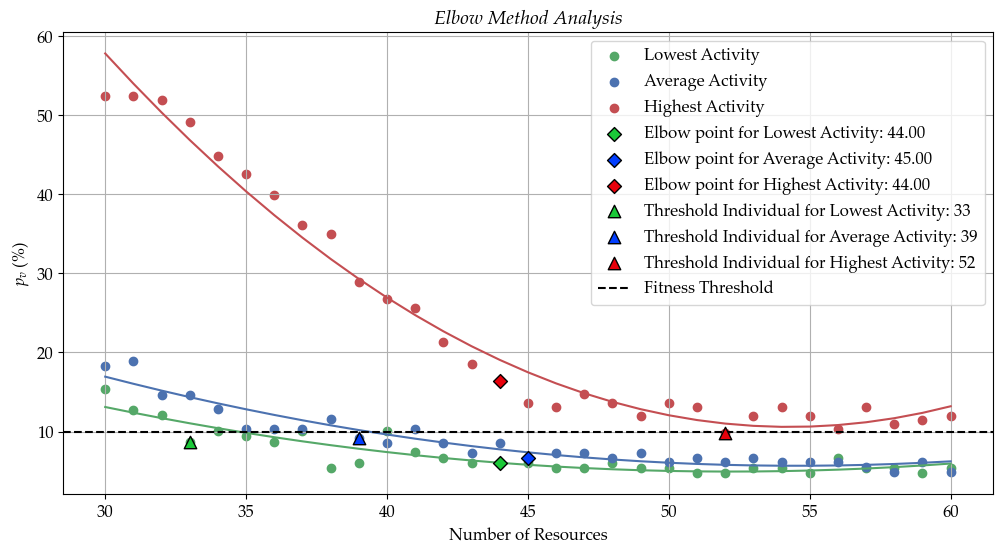

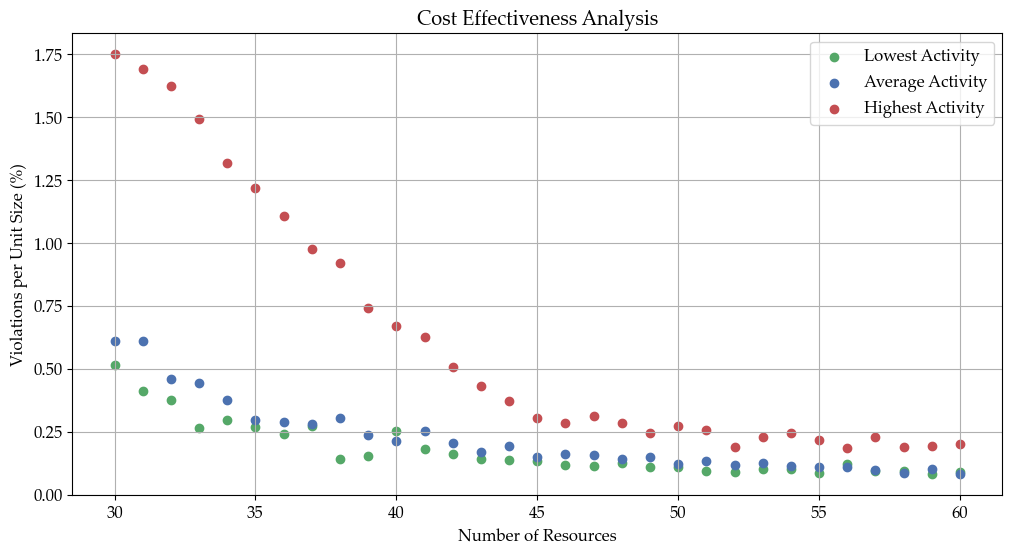

In [13]:
plot_analysis([subset_lowest, subset_average, subset_highest], objective="percentage_violations", degree=2)
